In [1]:
import numpy as np 
import pandas as pd 

# Transfer learning with combined data(English + few samples of Marathi)

In [2]:
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  # Show all columns
df = pd.read_csv('/kaggle/input/eng-xlmr/english_preprocessed (1) (1).csv')
print(df.head())

                                                                                                                                                                                                                                        text  \
0                                                    if you made it through this were not only able to start making money for yourself but sustain living that way all from home fuck these company corporate pig power to the people always   
1                                                                                                                                                                                 technically that is still turning back the clock dick head   
2  and you are the govt stop thinking about world medium liberal gang or any optic whatsoever and act now already if this is what a person at your level is facing then shudder to think the plight of common people in bengal bengalburning   
3                                       

In [3]:
# install transformers
!pip install "transformers ==4.33.1"
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 1.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 27.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.1 MB/s eta 0:00:0000:01:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.39.3
    Uninstalling transformers-4.39.3:
      Successfully uninstalled transformers-4.39.3


In [4]:
# load tokens
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [5]:
# print first text
df.text.values[0]

'if you made it through this were not only able to start making money for yourself but sustain living that way all from home fuck these company corporate pig power to the people always'

In [6]:
#Print tokens of first text
print({x : tokenizer.encode(x, add_special_tokens=False) for x in df.text.values[0].split()})

{'if': [2174], 'you': [398], 'made': [7228], 'it': [442], 'through': [8305], 'this': [903], 'were': [3542], 'not': [959], 'only': [4734], 'able': [19048], 'to': [47], 'start': [4034], 'making': [20662], 'money': [17265], 'for': [100], 'yourself': [31949], 'but': [1284], 'sustain': [205027], 'living': [38043], 'that': [450], 'way': [3917], 'all': [756], 'from': [1295], 'home': [5368], 'fuck': [40878], 'these': [6097], 'company': [14380], 'corporate': [145781], 'pig': [53408], 'power': [14537], 'the': [70], 'people': [3395], 'always': [11343]}


In [7]:
#drop null values
df = df.dropna()

In [8]:
import pandas as pd

# Assuming you have loaded your DataFrame df
# You can replace df with the name of your DataFrame

# Count the number of rows where the label is 1
num_label_1 = (df['label'] == 1).sum()

# Count the number of rows where the label is 0
num_label_0 = (df['label'] == 0).sum()

print("Number of rows where label is 1:", num_label_1)
print("Number of rows where label is 0:", num_label_0)




Number of rows where label is 1: 4051
Number of rows where label is 0: 4635


In [9]:
df.shape

(8686, 2)

# 

In [10]:
import torch
from transformers import XLMRobertaModel
from torch import nn

class CustomXLMRobertaForClassification(nn.Module):
    def __init__(self, num_labels):
        super(CustomXLMRobertaForClassification, self).__init__()
        self.num_labels = num_labels 
        self.roberta = XLMRobertaModel.from_pretrained("xlm-roberta-base")
        self.classifier = CustomRobertaClassificationHead(input_size=self.roberta.config.hidden_size, hidden_size=768, num_labels=num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            return loss,logits
        else:
            return logits
       



2024-05-02 10:54:19.855933: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 10:54:19.856050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 10:54:19.981060: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
class CustomRobertaClassificationHead(nn.Module):
    def __init__(self, input_size, hidden_size, num_labels):
        super(CustomRobertaClassificationHead, self).__init__()
        self.dense = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(0.1)
        self.additional_linear = nn.Linear(768, 768)
        self.out_proj = nn.Linear(hidden_size, num_labels)

    def forward(self, x):
        x = self.dropout(x)
        batch_size = x.size(0)
        x = x.view(-1, x.size(-1))
        x = nn.functional.relu(self.dense(x))
        x = self.dropout(x)
        x = x.view(batch_size, -1, 768)
        x = nn.functional.relu(self.additional_linear(x))
        x = self.dropout(x)
        x = x.mean(dim=1)
        x = self.out_proj(x)
        return x

# Create an instance of the custom model
# model = CustomXLMRobertaForClassification(num_labels=len(set(target)))
model = CustomXLMRobertaForClassification(num_labels=2)



model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [12]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('Using CPU')


Using GPU: Tesla T4


In [13]:
import pandas as pd
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  # Show all columns
df2 = pd.read_csv('/kaggle/input/mr-dataset/marathi_preprocessed_2.csv')
print(df2.head())

                                                                                                                     tweet  \
0                 आजच्या जनता दरबारात जळगाव जिल्ह्यातील चाळीसगावचे रहिवासी माजी सैनिक सोनू महाजन आले होते भाजपचे तत्कालीन…   
1                       कुणी कविता करत असतं तर कुणी कविता जगत असतं कुणी कविता वाचत असतं तर कुणाला कविताच वाचवत असते पल्लवी   
2        आम्हाला इतिहासातील औरंगजेबशी काही घेणे नाही आमच्या कडे आमचा बेकायदेशीर रित्या आलेला हक्काचा औरंगजेब आहे तो एका क…   
3                            गँभीर प्रकरण महाराष्ट्राची अवस्था बिकट आहे भाषणात मोठे शब्द वापरणे ऐकले कृती करावी उद्योग भी…   
4  कब्झा हा कन्नड चित्रपट लवकरच मराठी मध्ये डब्ब होऊन प्रदर्शित होणार आहे जर ह्या चित्रपटाला चांगला प्रतिसाद मिळाला तर आप…   

   label  
0      1  
1      1  
2      1  
3      1  
4      1  


In [14]:
# load tokens
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

In [15]:
#Print tokens of first text
print({x : tokenizer.encode(x, add_special_tokens=False) for x in df2.tweet.values[0].split()})

{'आजच्या': [3264, 2869], 'जनता': [27620], 'दरबारात': [208231, 2535], 'जळगाव': [231172], 'जिल्ह्यातील': [168231], 'चाळीसगावचे': [15179, 24718, 1472, 58733, 3360], 'रहिवासी': [774, 15159, 105346], 'माजी': [138139], 'सैनिक': [120458], 'सोनू': [120629, 5673], 'महाजन': [10373, 14136], 'आले': [21409], 'होते': [8358], 'भाजपचे': [75319, 3360], 'तत्कालीन…': [159136, 27]}


In [16]:
#drop null values
df2 = df2.dropna()

# Combined Training Data

In [17]:
df.head()

,text,label
0,if you made it through this were not only able to start making money for yourself but sustain living that way all from home fuck these company corporate pig power to the people always,0
1,technically that is still turning back the clock dick head,0
2,and you are the govt stop thinking about world medium liberal gang or any optic whatsoever and act now already if this is what a person at your level is facing then shudder to think the plight of common people in bengal bengalburning,1
3,soldier of japan who ha dick head,0
4,you would be better off asking who doe not think he is a sleazy shitbag lmao,0


In [18]:
df2.head()

,tweet,label
0,आजच्या जनता दरबारात जळगाव जिल्ह्यातील चाळीसगावचे रहिवासी माजी सैनिक सोनू महाजन आले होते भाजपचे तत्कालीन…,1
1,कुणी कविता करत असतं तर कुणी कविता जगत असतं कुणी कविता वाचत असतं तर कुणाला कविताच वाचवत असते पल्लवी,1
2,आम्हाला इतिहासातील औरंगजेबशी काही घेणे नाही आमच्या कडे आमचा बेकायदेशीर रित्या आलेला हक्काचा औरंगजेब आहे तो एका क…,1
3,गँभीर प्रकरण महाराष्ट्राची अवस्था बिकट आहे भाषणात मोठे शब्द वापरणे ऐकले कृती करावी उद्योग भी…,1
4,कब्झा हा कन्नड चित्रपट लवकरच मराठी मध्ये डब्ब होऊन प्रदर्शित होणार आहे जर ह्या चित्रपटाला चांगला प्रतिसाद मिळाला तर आप…,1


In [19]:
df2.rename(columns={'tweet': 'text'}, inplace=True)

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Split df2 into training and testing sets (where training contains only 20%)
train_df2, test_df2 = train_test_split(df2, test_size=0.9, random_state=42)

# Combine training data from df2 with df1
combined_df = pd.concat([df, train_df2], ignore_index=True)

# If you want to reset the index of the combined DataFrame
combined_df.reset_index(drop=True, inplace=True)


**Marathi samples**

In [21]:
train_df2.shape

(358, 2)

In [22]:
#Print tokens of first text
print({x : tokenizer.encode(x, add_special_tokens=False) for x in combined_df.text.values[0].split()})

{'if': [2174], 'you': [398], 'made': [7228], 'it': [442], 'through': [8305], 'this': [903], 'were': [3542], 'not': [959], 'only': [4734], 'able': [19048], 'to': [47], 'start': [4034], 'making': [20662], 'money': [17265], 'for': [100], 'yourself': [31949], 'but': [1284], 'sustain': [205027], 'living': [38043], 'that': [450], 'way': [3917], 'all': [756], 'from': [1295], 'home': [5368], 'fuck': [40878], 'these': [6097], 'company': [14380], 'corporate': [145781], 'pig': [53408], 'power': [14537], 'the': [70], 'people': [3395], 'always': [11343]}


In [23]:
#drop null values
combined_df = combined_df.dropna()

**Finding Max length of tokenized sentence**

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
max:  116
min:  3


(array([   0.,  500., 1000., 1500., 2000., 2500., 3000.]),
 [Text(0, 0.0, '0'),
  Text(0, 500.0, '500'),
  Text(0, 1000.0, '1000'),
  Text(0, 1500.0, '1500'),
  Text(0, 2000.0, '2000'),
  Text(0, 2500.0, '2500'),
  Text(0, 3000.0, '3000')])

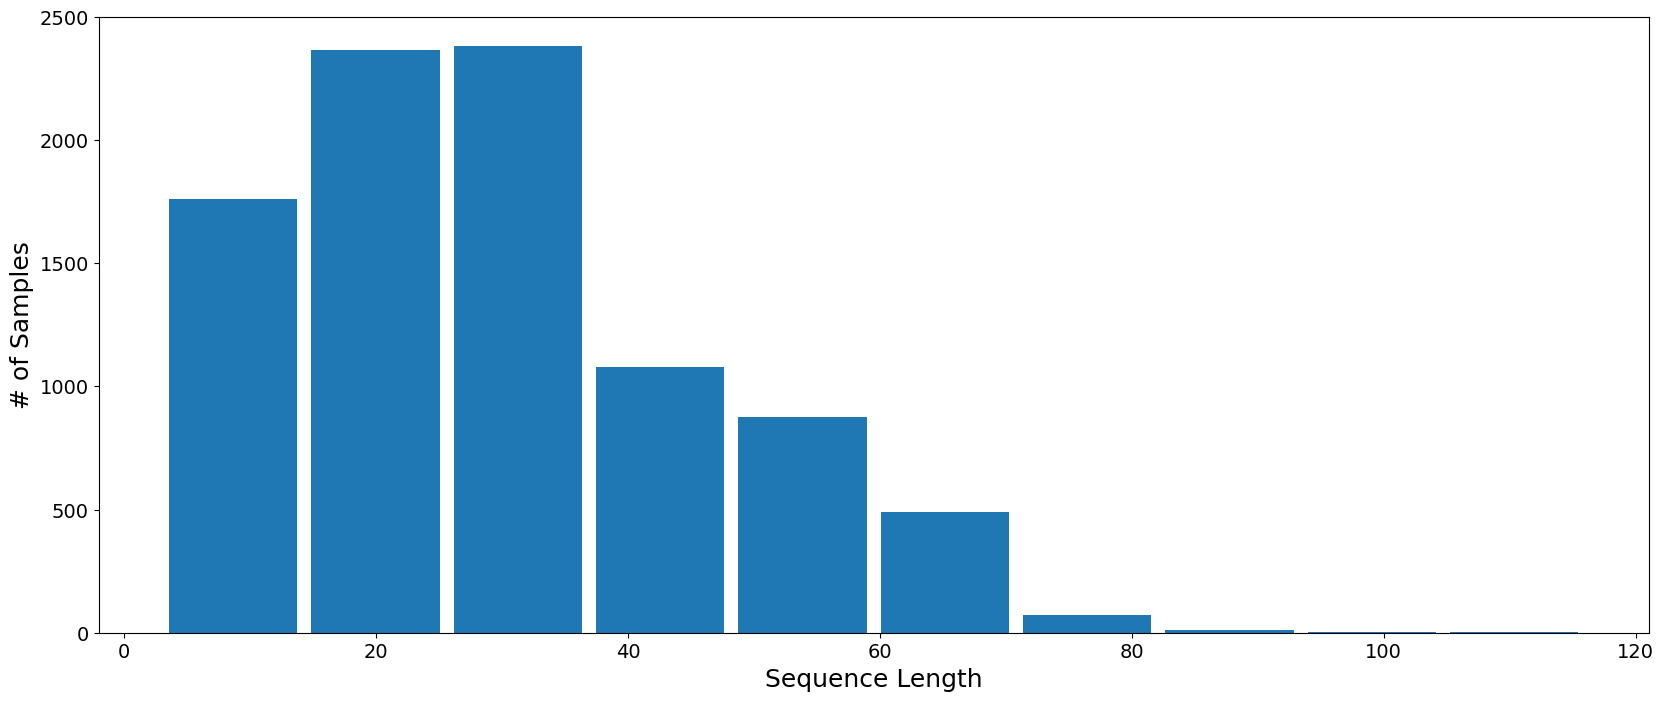

In [24]:
# install matplotlib
!pip install matplotlib
# tokenize the text feature
tokenized_feature_raw = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            combined_df.text.values.tolist(),
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True
                   )
# collect tokenized sentence length
token_sentence_length = [len(x) for x in tokenized_feature_raw['input_ids']]
print('max: ', max(token_sentence_length))
print('min: ', min(token_sentence_length))
# plot the distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.hist(token_sentence_length, rwidth = 0.9)
plt.xlabel('Sequence Length', fontsize = 18)
plt.ylabel('# of Samples', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

**initializing features and target**

In [25]:
# identify features and target
features = combined_df.text.values.tolist()
target = combined_df.label.values.tolist()

**tokenize features**

In [26]:
# tokenize features
MAX_LEN = 100
tokenized_feature = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            features,
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True,
                            # Add empty tokens if len(text)<MAX_LEN
                            padding = 'max_length',
                            # Truncate all sentences to max length
                            truncation=True,
                            # Set the maximum length
                            max_length = MAX_LEN,
                            # Return attention mask
                            return_attention_mask = True,
                            # Return pytorch tensors
                            return_tensors = 'pt'
                   )

In [27]:
from transformers import AdamW, get_linear_schedule_with_warmup

**Creating training dataloader**

In [28]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

# Assuming features and target are your tokenized features and target
features = tokenized_feature['input_ids']
masks = tokenized_feature['attention_mask']
target = target

# Convert features and target to tensors
features_tensor = torch.tensor(features)
masks_tensor = torch.tensor(masks)
target_tensor = torch.tensor(target)

# Create TensorDataset
train_data = TensorDataset(features_tensor, masks_tensor, target_tensor)

# Define batch size
batch_size = 32

# Create DataLoader with RandomSampler
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


/tmp/ipykernel_34/3600969267.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features_tensor = torch.tensor(features)
/tmp/ipykernel_34/3600969267.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks_tensor = torch.tensor(masks)


**Defining optimizer**

In [29]:
# Optimizer 
optimizer = AdamW(model.parameters(),
                  lr = 1e-5,
                  eps = 1e-8,
                  weight_decay=0.01
                )

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


**Defining scheduler and epochs**

In [30]:
# Number of training epochs
epochs = 5
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 5,
                                            num_training_steps = total_steps)

In [31]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('Using CPU')


Using GPU: Tesla T4


In [32]:
#move model to device
model.to(device)

CustomXLMRobertaForClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, b

In [33]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Training loop

In [34]:
from sklearn.metrics import classification_report

train_losses= []


for n in range(epochs):
    # List to store predictions and ground truth labels for both training and validation sets
    train_preds = []
    train_labels_all = []


    train_loss = 0

    start_time = time.time()
    
    # Calculate number of mini-batches for training and validation sets
    num_mb_train = len(train_dataloader)


    # Training phase
    for k, (mb_x, mb_m, mb_y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        model.train()

        mb_x = mb_x.to(device)
        mb_m = mb_m.to(device)
        mb_y = mb_y.to(device)

        outputs = model(mb_x, attention_mask=mb_m, labels=mb_y)
        loss = outputs[0]
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.data / num_mb_train

        # Append predictions and labels
        train_preds += torch.argmax(outputs[1], dim=1).cpu().tolist()
        train_labels_all += mb_y.cpu().tolist()

    # Compute metrics
    train_report = classification_report(train_labels_all, train_preds, target_names=['NOT', 'HOF'])

    print(f'Training report after iteration {n+1}:\n{train_report}')


    train_losses.append(train_loss.cpu())

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
    print(f'Time: {epoch_mins}m {epoch_secs}s')


Training report after iteration 1:
              precision    recall  f1-score   support

         NOT       0.65      0.80      0.72      4768
         HOF       0.70      0.52      0.60      4276

    accuracy                           0.67      9044
   macro avg       0.67      0.66      0.66      9044
weighted avg       0.67      0.67      0.66      9044

Time: 2.0m 35.74591779708862s
Training report after iteration 2:
              precision    recall  f1-score   support

         NOT       0.82      0.82      0.82      4768
         HOF       0.80      0.80      0.80      4276

    accuracy                           0.81      9044
   macro avg       0.81      0.81      0.81      9044
weighted avg       0.81      0.81      0.81      9044

Time: 2.0m 38.56232142448425s
Training report after iteration 3:
              precision    recall  f1-score   support

         NOT       0.85      0.86      0.85      4768
         HOF       0.84      0.83      0.84      4276

    accuracy     

**Test data (Marathi)**

In [35]:
#Print tokens of first text
print({x : tokenizer.encode(x, add_special_tokens=False) for x in test_df2.text.values[0].split()})

{'जशी': [6960, 9155], 'दृष्टी': [6, 95099, 659], 'तशी': [3418, 9155], 'सृष्टी': [6, 222961, 659]}


**Finding Max length of tokenized sentence**

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
max:  380
min:  3


(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.]),
 [Text(0, 0.0, '0'),
  Text(0, 500.0, '500'),
  Text(0, 1000.0, '1000'),
  Text(0, 1500.0, '1500'),
  Text(0, 2000.0, '2000'),
  Text(0, 2500.0, '2500'),
  Text(0, 3000.0, '3000'),
  Text(0, 3500.0, '3500')])

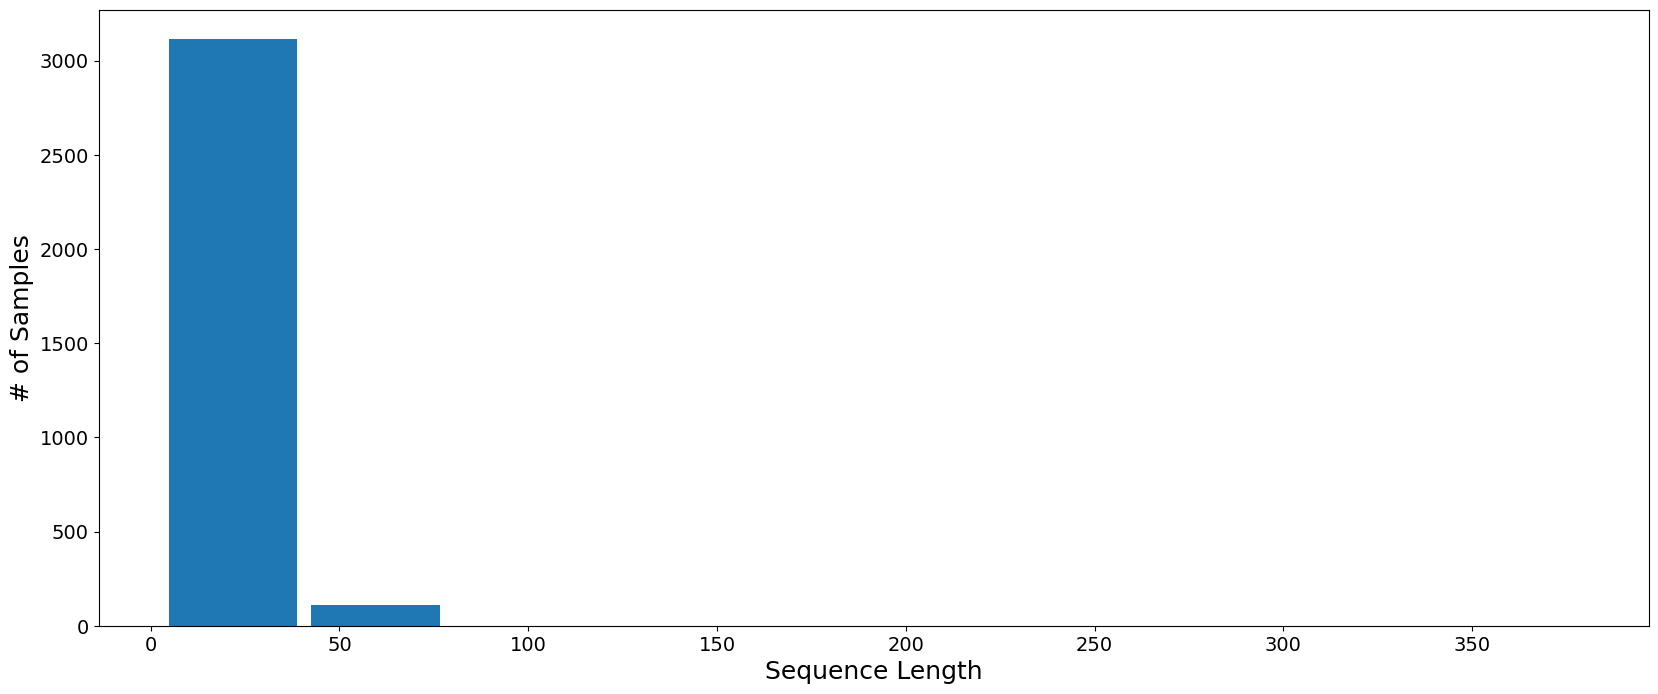

In [36]:
# install matplotlib
!pip install matplotlib
# tokenize the text feature
tokenized_feature_raw = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            test_df2.text.values.tolist(),
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True
                   )
# collect tokenized sentence length
token_sentence_length = [len(x) for x in tokenized_feature_raw['input_ids']]
print('max: ', max(token_sentence_length))
print('min: ', min(token_sentence_length))
# plot the distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.hist(token_sentence_length, rwidth = 0.9)
plt.xlabel('Sequence Length', fontsize = 18)
plt.ylabel('# of Samples', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

**defining features and target for test data**

In [37]:
# identify features and target
features = test_df2.text.values.tolist()
target = test_df2.label.values.tolist()

**Tokenize features**

In [38]:
# tokenize features
MAX_LEN = 80
tokenized_feature = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            features,
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True,
                            # Add empty tokens if len(text)<MAX_LEN
                            padding = 'max_length',
                            # Truncate all sentences to max length
                            truncation=True,
                            # Set the maximum length
                            max_length = MAX_LEN,
                            # Return attention mask
                            return_attention_mask = True,
                            # Return pytorch tensors
                            return_tensors = 'pt'
                   )

**create test dataloader**

In [39]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

# Assuming features and target are your tokenized features and target
features = tokenized_feature['input_ids']
masks = tokenized_feature['attention_mask']
target = target

# Convert features and target to tensors
features_tensor = torch.tensor(features)
masks_tensor = torch.tensor(masks)
target_tensor = torch.tensor(target)

# Create TensorDataset
test_data = TensorDataset(features_tensor, masks_tensor, target_tensor)

# Define batch size
batch_size = 16

# Create DataLoader with RandomSampler
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


/tmp/ipykernel_34/3427101683.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features_tensor = torch.tensor(features)
/tmp/ipykernel_34/3427101683.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks_tensor = torch.tensor(masks)


# Testing Phase

In [40]:
# Testing 
model.eval()
test_preds = []
test_labels_all = []

with torch.no_grad():
    for mb_x, mb_m, mb_y in test_dataloader:
        mb_x = mb_x.to(device)
        mb_m = mb_m.to(device)
        mb_y = mb_y.to(device)

        outputs = model(mb_x, attention_mask=mb_m, labels=mb_y)
        test_preds += torch.argmax(outputs[1], dim=1).cpu().tolist()
        test_labels_all += mb_y.cpu().tolist()

# Compute and print classification report for testing
test_report = classification_report(test_labels_all, test_preds, target_names=['NOT', 'HOF'])
print(f'Testing report:\n{test_report}')

Testing report:
              precision    recall  f1-score   support

         NOT       0.71      0.75      0.73      1045
         HOF       0.87      0.85      0.86      2182

    accuracy                           0.82      3227
   macro avg       0.79      0.80      0.79      3227
weighted avg       0.82      0.82      0.82      3227



# Confusion Matrix

**Here we can see that by giving few examples of target language F1 score is improved**

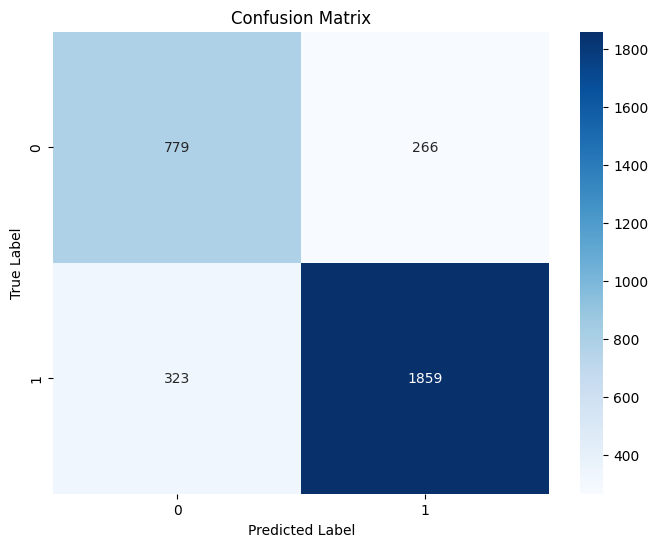

In [41]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(test_labels_all, test_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [42]:
from sklearn.metrics import f1_score


# Calculate F1 score
f1score = f1_score(test_labels_all, test_preds)

print("F1 Score:", f1score)


F1 Score: 0.8632458788019504


# Testing on provided input 0:Hate 1:Non Hate

In [43]:

# Define your input sentence
sentence = "सत्तेसाठी केलेली लाचारी"
# Tokenize input sentence
encoding = tokenizer(sentence, return_tensors="pt")

# Move input tensors to the same device as the model
encoding = {k: v.to(device) for k, v in encoding.items()}

# Perform inference
with torch.no_grad():
    outputs = model(**encoding)

# Get predicted logits
logits = outputs[0]

# Get predicted class index (index with the highest probability)
predicted_class_index = logits.argmax(-1).item()

# Print predicted class index
print("Predicted class index:", predicted_class_index)

Predicted class index: 0


In [44]:
torch.save(model.state_dict(), 'custom_model_combined_mr_eng.pth')

In [45]:
import zipfile
import os

# Define the file paths
model_state_dict_path = 'custom_model_combined_mr_eng.pth'
zip_file_name = 'model_files.zip'

# Create a zip file
with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    # Add the model state dictionary file to the zip
    zipf.write(model_state_dict_path, os.path.basename(model_state_dict_path))

print(f"Zip file '{zip_file_name}' created successfully!")

Zip file 'model_files.zip' created successfully!
